In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Google Colab allows us to use a GPU. Cool!
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 1. Load data
The original 809 images from kaggle have been sorted into folders according to type, and converted to jpegs. Let's load that data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/Colab Notebooks/sorted1/')
image_count = len(list(data_dir.glob('./*/*')))
print("Found " + str(image_count) + " images in total")

Found 809 images in total


Now let's convert the images into training and validation sets using the built-in function [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory), which generates a Tensorflow [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object.

We'll use an 80-20 split for training and validation. Also, the "categorical" keyword for the label mode means we are using one-hot vectors for our labels.

In [4]:
pparams = dict(directory=data_dir,
                label_mode = 'categorical',
                validation_split=0.2,
                seed=7,
                image_size=(120, 120))

training_data = tf.keras.preprocessing.image_dataset_from_directory(
                    subset="training", **pparams)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
                    subset="validation", **pparams)

print("\nPokemon Types:")
print(training_data.class_names)
NUMCLASSES = len(training_data.class_names)

Found 809 files belonging to 18 classes.
Using 648 files for training.
Found 809 files belonging to 18 classes.
Using 161 files for validation.

Pokemon Types:
['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']


We can view some example images labelled by type.

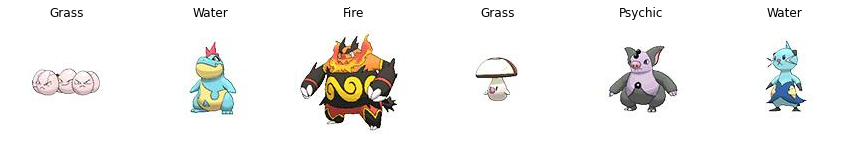

In [26]:
plt.figure(figsize=(15, 3))
for images, labels in training_data.take(1):
  for i in range(6):
    ax = plt.subplot(1, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    arr = np.array(labels[i])
    index = np.where(arr == 1)
    plt.title(training_data.class_names[index[0][0]])
    plt.axis("off")

# 2. Create a simple neural network

In [32]:
import keras.layers as layers

def create_CNN():
    # instantiate model
    model = tf.keras.models.Sequential()
    # add rescaling layer
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(120, 120, 3)))
    # add first convolutional layer with 18 filters
    model.add(layers.Conv2D(18, 5, activation='relu'))
    # add 2D pooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # add second convolutional layer with 36 filters
    model.add(layers.Conv2D(36, 5, activation='relu'))
    # apply dropout with rate 0.5
    model.add(layers.Dropout(0.5))
    # add 2D pooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # flatten data
    model.add(layers.Flatten())
    # add a dense all-to-all relu layer
    model.add(layers.Dense(36*4*4, activation='relu'))
    # apply dropout with rate 0.5
    model.add(layers.Dropout(0.5))
    # soft-max layer
    model.add(layers.Dense(NUMCLASSES, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    
    return model

In [39]:
import keras
batch_size = 32
epochs = 15

model = create_CNN()

# train CNN
history = model.fit(training_data,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=validation_data)

Epoch 1/15
21/21 [==============================] - 1s 64ms/step - loss: 4.5314 - accuracy: 0.1173 - val_loss: 2.8407 - val_accuracy: 0.1429
Epoch 2/15
21/21 [==============================] - 1s 61ms/step - loss: 2.7961 - accuracy: 0.1435 - val_loss: 2.6955 - val_accuracy: 0.1677
Epoch 3/15
21/21 [==============================] - 1s 61ms/step - loss: 2.6516 - accuracy: 0.1713 - val_loss: 2.6781 - val_accuracy: 0.2609
Epoch 4/15
21/21 [==============================] - 1s 62ms/step - loss: 2.5774 - accuracy: 0.2361 - val_loss: 2.6492 - val_accuracy: 0.1739
Epoch 5/15
21/21 [==============================] - 1s 58ms/step - loss: 2.4534 - accuracy: 0.2469 - val_loss: 2.6332 - val_accuracy: 0.2298
Epoch 6/15
21/21 [==============================] - 1s 61ms/step - loss: 2.2281 - accuracy: 0.3302 - val_loss: 2.6064 - val_accuracy: 0.1739
Epoch 7/15
21/21 [==============================] - 1s 59ms/step - loss: 2.0432 - accuracy: 0.3704 - val_loss: 2.5328 - val_accuracy: 0.2174
Epoch 8/15
21

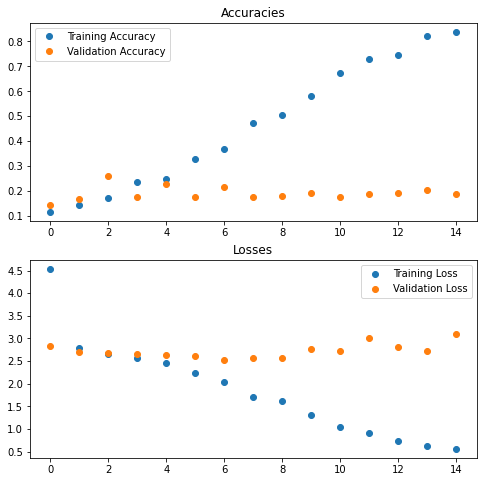

Maximum validation accuracy achieved: 0.260869562625885


In [42]:
# Plot accuracies and losses to see where overfitting happens and how our model
# performs on the validation set

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(range(epochs), history.history['accuracy'], 'o', label='Training Accuracy')
plt.plot(range(epochs), history.history['val_accuracy'], 'o', label='Validation Accuracy')
plt.legend()
plt.title('Accuracies')

plt.subplot(2, 1, 2)
plt.plot(range(epochs), history.history['loss'], 'o', label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], 'o', label='Validation Loss')
plt.legend()
plt.title('Losses')
plt.show()

print("Maximum validation accuracy achieved: " + str(np.max(history.history['val_accuracy'])))

Let's take a closer look at the predictions for the validation set.

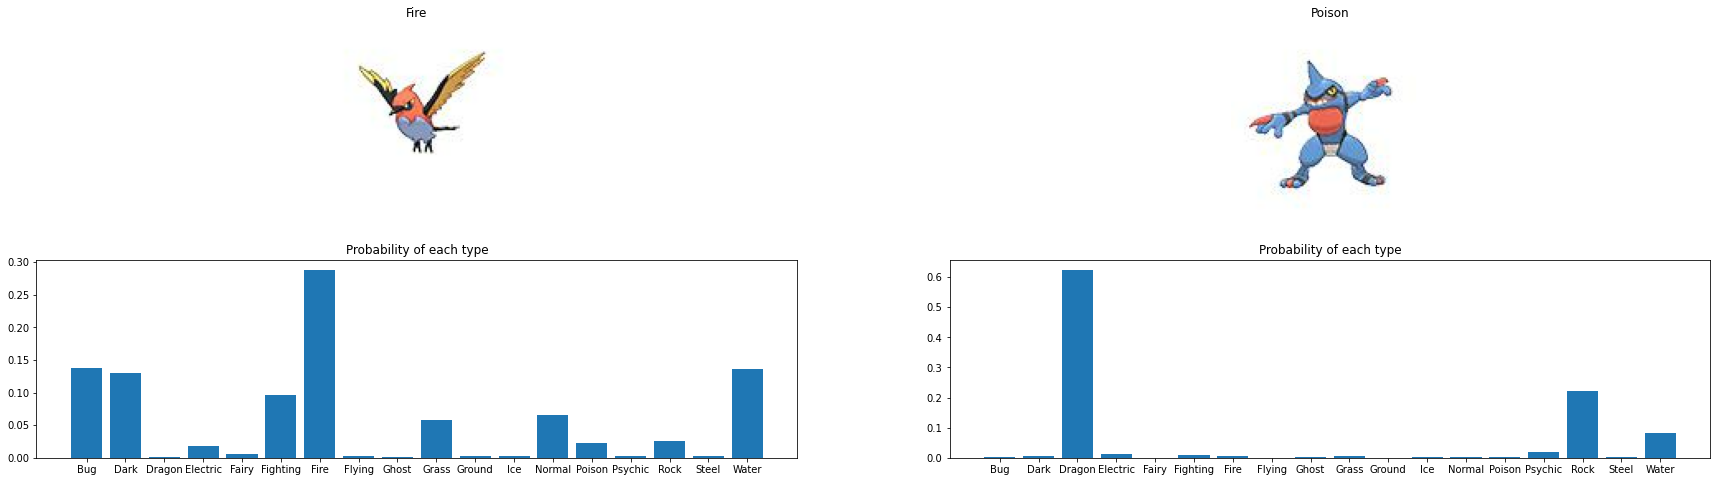

In [78]:
SAMPLES = 2

plt.figure(figsize=(30, 8))
for images, labels in validation_data.take(1):
  predictions = model.predict(images)
  for i in range(SAMPLES):
    ax = plt.subplot(2, SAMPLES, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    arr = np.array(labels[i])
    index = np.where(arr == 1)
    plt.title("True type: " + training_data.class_names[index[0][0]])
    plt.axis("off")

    plt.subplot(2, SAMPLES, i + SAMPLES + 1)
    plt.title("Probability of each type")
    plt.bar(training_data.class_names, predictions[i])
 

This basic neural network doesn't perform very well. Let's see how well we can do using ResNet, and applying an automatic hyperparameter tuner, [Keras Tuner](https://keras-team.github.io/keras-tuner/).

# 3. HyperResNet

In [86]:
!pip install -q -U keras-tuner
import kerastuner as kt

In [87]:
hypermodel = kt.applications.HyperResNet(
    input_shape=(120, 120, 3), classes=NUMCLASSES)

tuner = kt.Hyperband(hypermodel,
                     objective = 'val_accuracy', 
                     max_epochs = 20)

tuner.search(training_data,
             epochs=40,
             validation_data=validation_data)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [90]:
best_hps = tuner.get_best_hyperparameters()[0]
optim_model = tuner.hypermodel.build(best_hps)
optim_history = optim_model.fit(
    training_data, epochs = 10, validation_data = validation_data)

Epoch 1/10
21/21 [==============================] - 8s 398ms/step - loss: 4.6200 - accuracy: 0.0880 - val_loss: 3.0776 - val_accuracy: 0.1677
Epoch 2/10
21/21 [==============================] - 6s 290ms/step - loss: 3.2157 - accuracy: 0.1250 - val_loss: 3.2808 - val_accuracy: 0.0186
Epoch 3/10
21/21 [==============================] - 6s 290ms/step - loss: 2.8093 - accuracy: 0.2099 - val_loss: 4.3513 - val_accuracy: 0.0186
Epoch 4/10
21/21 [==============================] - 6s 286ms/step - loss: 2.1292 - accuracy: 0.3796 - val_loss: 5.1541 - val_accuracy: 0.0683
Epoch 5/10
21/21 [==============================] - 6s 286ms/step - loss: 2.3966 - accuracy: 0.3272 - val_loss: 6.1598 - val_accuracy: 0.0186
Epoch 6/10
21/21 [==============================] - 6s 287ms/step - loss: 2.3574 - accuracy: 0.3488 - val_loss: 6.7745 - val_accuracy: 0.0186
Epoch 7/10
21/21 [==============================] - 6s 286ms/step - loss: 2.2514 - accuracy: 0.4043 - val_loss: 7.0602 - val_accuracy: 0.0373
Epoch 

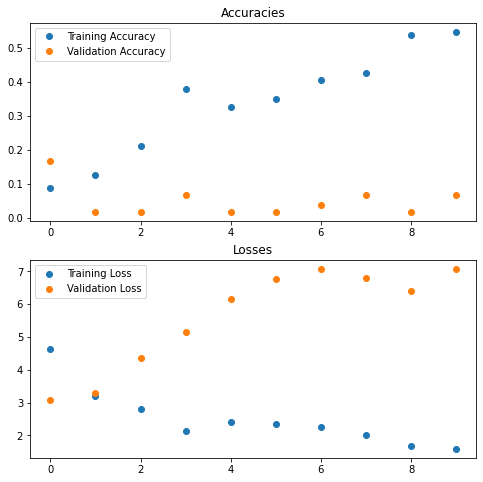

Maximum validation accuracy achieved: 0.1677018702030182


In [92]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(range(10), optim_history.history['accuracy'], 'o', label='Training Accuracy')
plt.plot(range(10), optim_history.history['val_accuracy'], 'o', label='Validation Accuracy')
plt.legend()
plt.title('Accuracies')

plt.subplot(2, 1, 2)
plt.plot(range(10), optim_history.history['loss'], 'o', label='Training Loss')
plt.plot(range(10), optim_history.history['val_loss'], 'o', label='Validation Loss')
plt.legend()
plt.title('Losses')
plt.show()

print("Maximum validation accuracy achieved: " + str(np.max(optim_history.history['val_accuracy'])))

Notes to self: 
- Try a different pre-trained neural net that is trained on pixelated images
- Print hyperparameters used for ResNet
- Apply hyperparameter tuner to CNN in part 2